In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

In [2]:
df2 = pd.read_csv('~/Downloads/hotelforecast2.csv', parse_dates=['Year'], index_col='Year')
df2

,Occupancy,Adr,PBT%
Year,,,
2009-01-01,66,7416,0.260
2010-01-01,62,5447,0.180
2011-01-01,68,5916,0.130
2012-01-01,64,6314,0.070
2013-01-01,64,6050,-0.002
2014-01-01,65,5647,-0.034
2015-01-01,63,5900,-0.020
2016-01-01,63,6167,-0.030
2017-01-01,66,6084,0.005


In [3]:
# Causality Test

maxlag=3
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df2, variables = df2.columns)  

,Occupancy_x,Adr_x,PBT%_x
Occupancy_y,1.0000,0.0000,0.1569
Adr_y,0.0003,1.0000,0.0012
PBT%_y,0.0000,0.0157,1.0000


In [4]:
# Cointegration Test

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,3)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Occupancy ::  157.5     > 24.2761   =>   True
Adr    ::  44.26     > 12.3212   =>   True
PBT%   ::  0.03      > 4.1296    =>   False


In [5]:
# VAR Model

model = VAR(df2)
x = model.select_order(maxlags=2)
x.summary()

/Users/ramakrishna/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/ramakrishna/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


,AIC,BIC,FPE,HQIC
0,6.929,7.019,1023.,6.829
1,6.241,6.604*,591.7*,5.843
2,6.112*,6.747,1231.,5.415*


In [6]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Mar, 2021
Time:                     09:38:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.74714
Nobs:                     10.0000    HQIC:                   5.41465
Log likelihood:          -52.1267    FPE:                    1230.92
AIC:                      6.11171    Det(Omega_mle):         250.543
--------------------------------------------------------------------
Results for equation Occupancy
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              101.952593        88.759433            1.149           0.251
L1.Occupancy        -0.190419         0.756191           -0.252           0.801
L1.Adr              -0.002104         0.002853           -0.

In [7]:
# Checking for Serial Correlation of residuals

out = durbin_watson(model_fitted.resid)

for col, val in zip(df2.columns, out):
    print((col), ':', round(val, 2))

Occupancy : 1.39
Adr : 1.61
PBT% : 3.51


In [8]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df2.values[-lag_order:]
forecast_input

2


array([[ 6.400e+01,  6.725e+03,  2.000e-02],
       [ 5.900e+01,  7.423e+03, -1.000e-02]])

In [9]:
# forecasting

nobs = 1
df2_train, df2_test = df2[0:-nobs], df2[-nobs:]

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df2_forecast = pd.DataFrame(fc, index=df2.index[-nobs:], columns=df2.columns)
df2_forecast

,Occupancy,Adr,PBT%
Year,,,
2020-01-01,63.443228,6547.990584,-0.004371


In [10]:
model.select_order(2)
results = model.fit(maxlags=2, ic='aic')
results.forecast(df2.values[-lag_order:], 1)

array([[ 6.34432284e+01,  6.54799058e+03, -4.37148438e-03]])

In [11]:
model.select_order(2)
results = model.fit(maxlags=2, ic='aic')
results.forecast(df2.values[-lag_order:], 2)

array([[ 6.34432284e+01,  6.54799058e+03, -4.37148438e-03],
       [ 6.74386572e+01,  5.45750871e+03,  6.80019677e-02]])

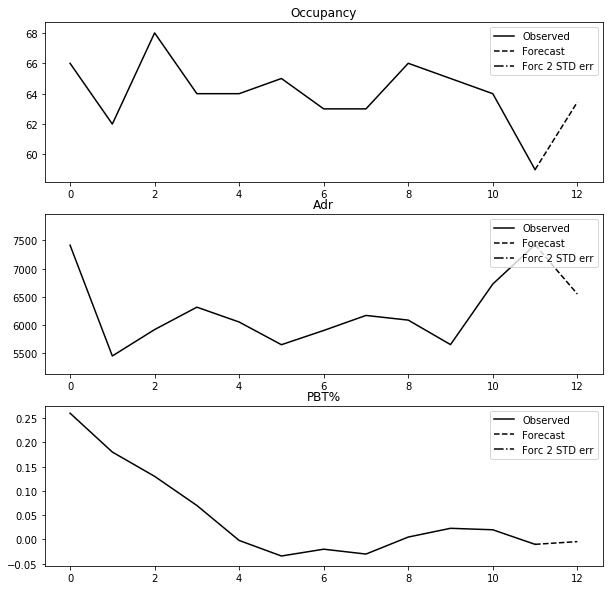

In [12]:
results.plot_forecast(1);

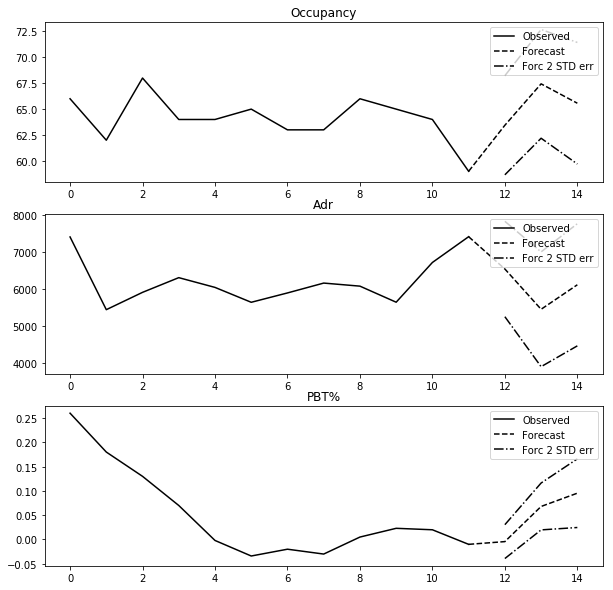

In [13]:
results.plot_forecast(3);

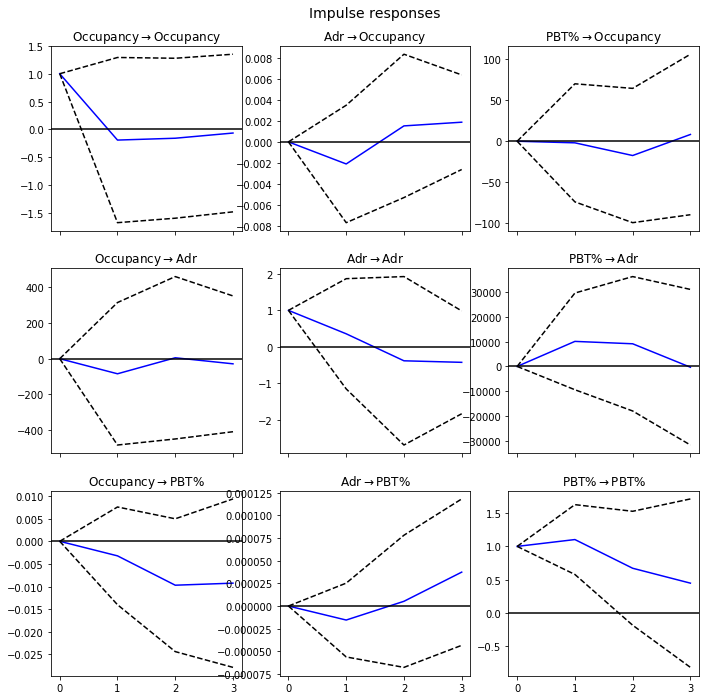

In [14]:
# Impulse Recursive Function

irf = results.irf(3)
irf.plot(orth=False);

In [15]:
# Forecast Error Variance Decomposition

fevd = results.fevd(3)
fevd.summary()

FEVD for Occupancy
     Occupancy       Adr      PBT%
0     1.000000  0.000000  0.000000
1     0.871878  0.128010  0.000112
2     0.859885  0.132863  0.007251

FEVD for Adr
     Occupancy       Adr      PBT%
0     0.539853  0.460147  0.000000
1     0.547702  0.418295  0.034002
2     0.565257  0.380151  0.054592

FEVD for PBT%
     Occupancy       Adr      PBT%
0     0.072922  0.260450  0.666629
1     0.078159  0.151592  0.770250
2     0.442402  0.125321  0.432277




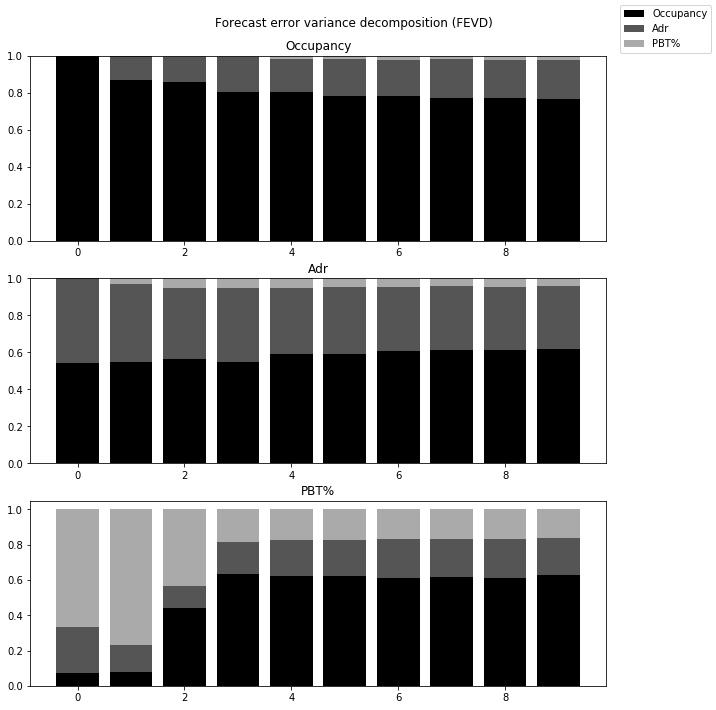

In [16]:
results.fevd(10).plot();